In [19]:
#IMPORTS
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Análisis Exploratorio de datos

In [20]:
df = pd.read_csv("dataset\healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [21]:
df.shape

(5110, 12)

In [22]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [23]:
#BMI Tiene 201 valores nulos, por lo que los reemplazaremos con la media
df['bmi'].fillna(df['bmi'].mean(), inplace=True)


In [24]:
#Dropeamos ID ya que no es relevante
df = df.drop("id",axis=1)

#Usamos binary encoding para ever_married
df['ever_married'] = df['ever_married'].map( 
                   {'Yes':1 ,'No':0})
df['ever_married'].value_counts()

ever_married
1    3353
0    1757
Name: count, dtype: int64

In [25]:
#  3.9% of rows are having NULLs so we can drop them
df.isna().sum()                                              

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [26]:
# Gender tiene 1 valor diferente que es Other, por lo que lo eliminaremos
df['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [27]:
df = df[df['gender'] != 'Other']

# Ahora solo tenemos 2 valores en Gender
df['gender'].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

In [28]:
# mas del 95% de los datos son de la clase 0, por lo que es un dataset desbalanceado, lo que puede afectar el rendimiento del modelo
df['stroke'].value_counts()               

stroke
0    4860
1     249
Name: count, dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int64  
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 479.0+ KB


In [30]:
#tomamos las columnas numericas para el modelo
numerical_df = df[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','stroke']]

In [61]:
df['age'].describe()

count   5109.00
mean      43.22
std       22.63
min        0.00
25%       25.00
50%       45.00
75%       61.00
max       82.00
Name: age, dtype: float64

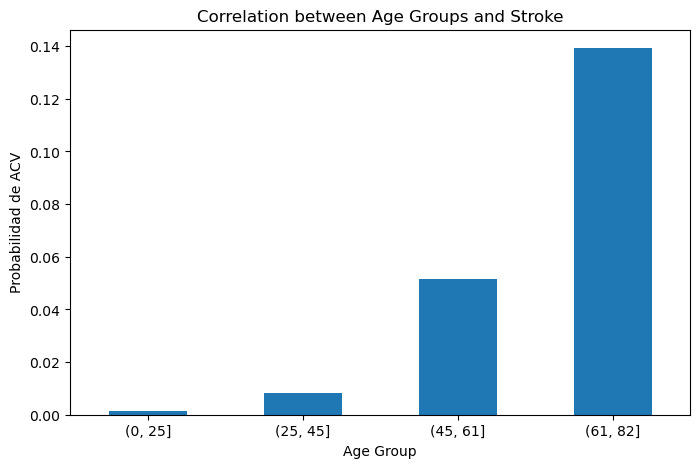

In [64]:
# Definir los rangos de edad en base a la media y la desviación estándar
age_ranges = [0, 25, 45, 61, 82]

# Crear binnings para las edades
df['age_group'] = pd.cut(df['age'], bins=age_ranges)

# Calcular la correlacion entre las edades y si tuvieron un ACV
correlation = df.groupby('age_group')['stroke'].mean()

plt.figure(figsize=(8, 5))
correlation.plot(kind='bar')
plt.xlabel('Age Group')
plt.ylabel('Probabilidad de ACV')
plt.title('Correlation between Age Groups and Stroke')
plt.xticks(rotation=0) 
plt.show()

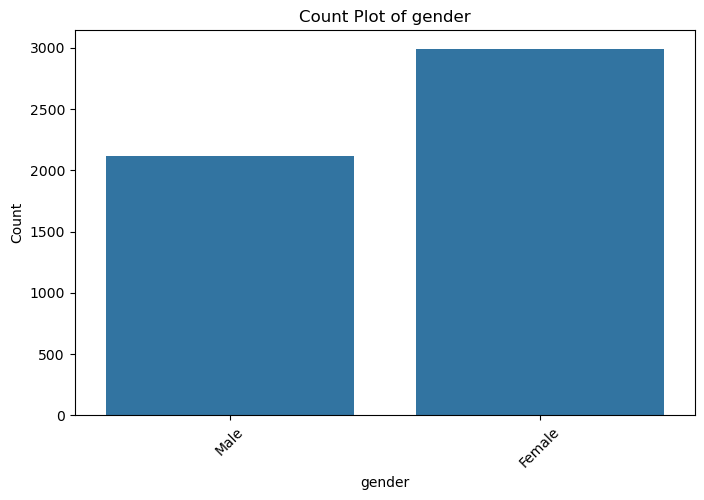

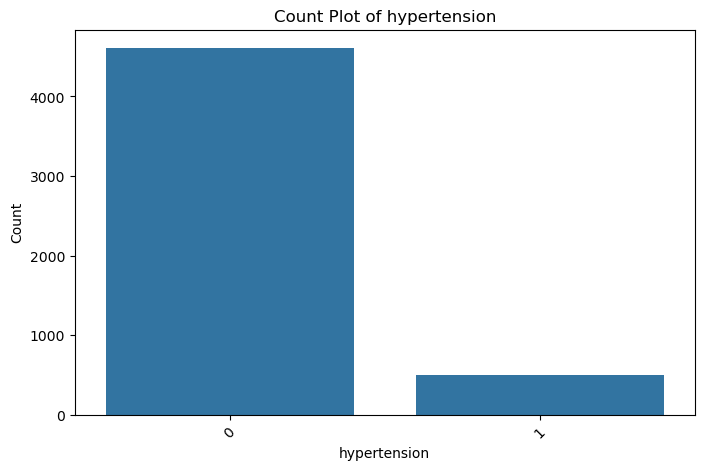

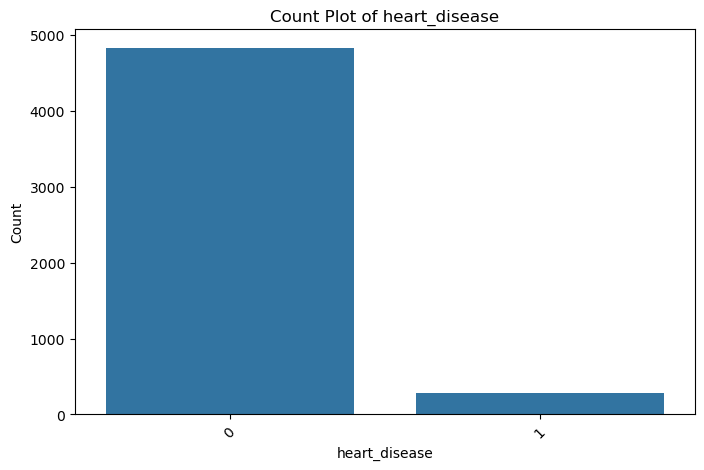

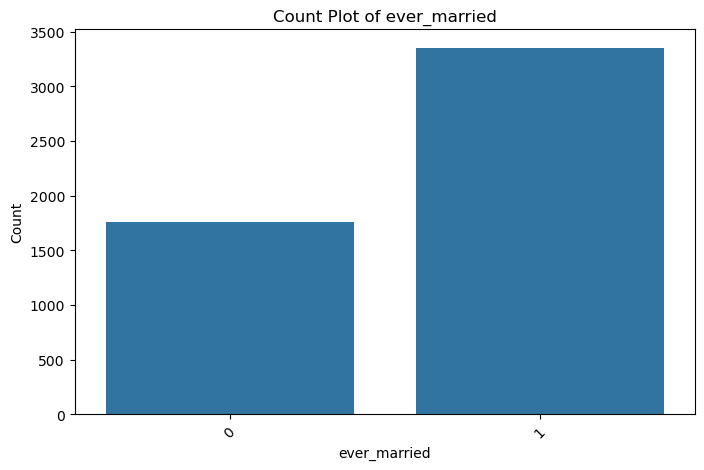

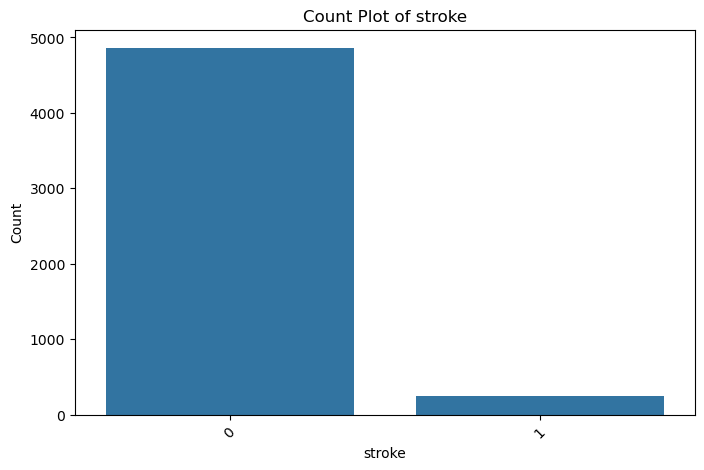

In [32]:
ColumnsForCountPlot = ['gender','hypertension','heart_disease','ever_married','stroke']
for column in ColumnsForCountPlot:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[column])
    plt.title(f'Count Plot of {column}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

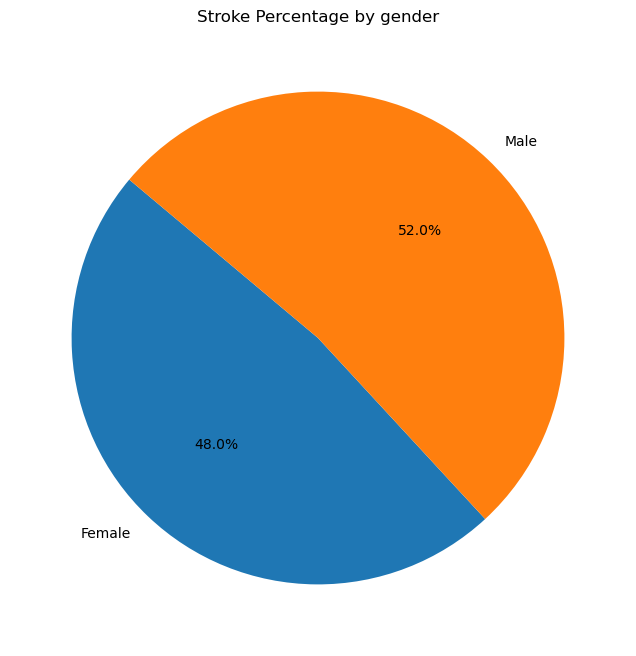

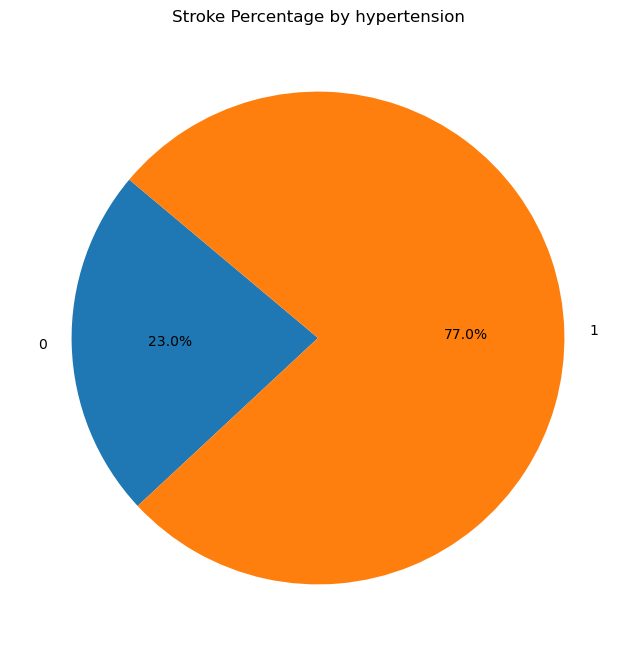

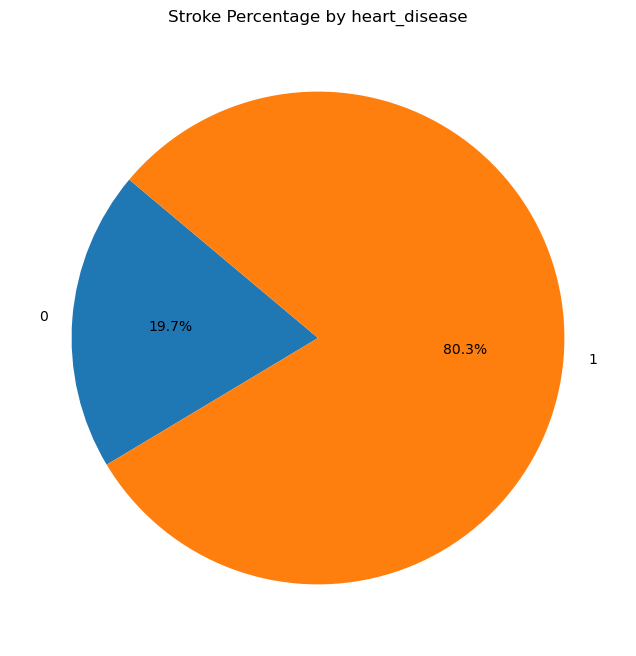

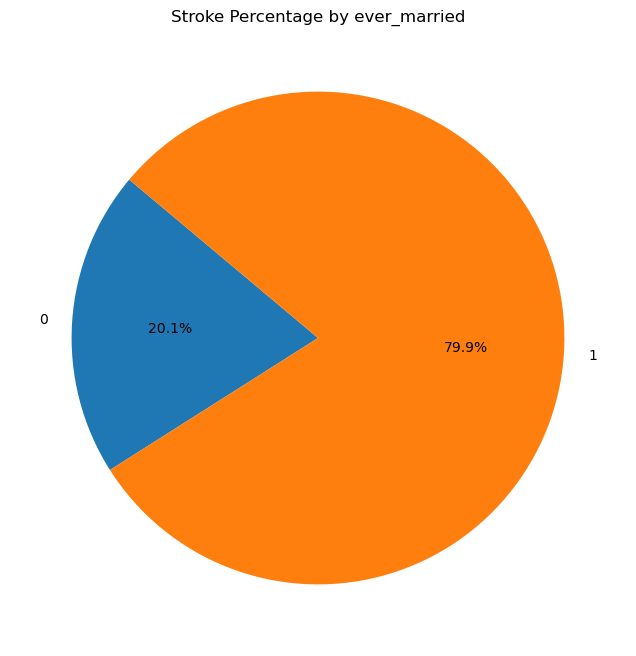

In [33]:
ColumnsForCountPlot = ['gender','hypertension','heart_disease','ever_married']
for column in ColumnsForCountPlot:
    # Calculate the percentage of stroke occurrences for each category in the column
    stroke_percentages = df.groupby(column)['stroke'].mean() * 100

    plt.figure(figsize=(8, 8))
    plt.pie(stroke_percentages, labels=stroke_percentages.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Stroke Percentage by {column}')
    plt.show()

In [34]:
corr = numerical_df.corr()

<Axes: >

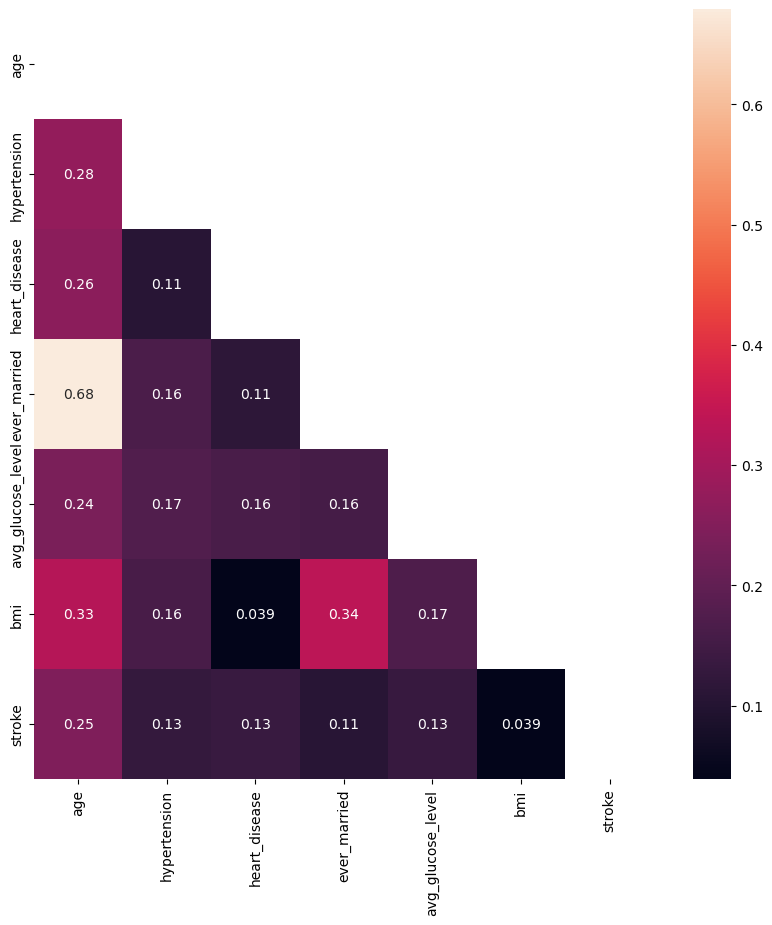

In [35]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,mask = np.triu(np.ones_like(corr, dtype=bool)))

In [36]:
df = pd.get_dummies(df).astype(int)
df.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,1,228,36,1,0,1,0,0,1,0,0,0,1,0,1,0,0
1,61,0,0,1,202,28,1,1,0,0,0,0,1,0,1,0,0,0,1,0
2,80,0,1,1,105,32,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49,0,0,1,171,34,1,1,0,0,0,1,0,0,0,1,0,0,0,1
4,79,1,0,1,174,24,1,1,0,0,0,0,1,0,1,0,0,0,1,0


In [37]:
df.shape

(5109, 20)

<Axes: >

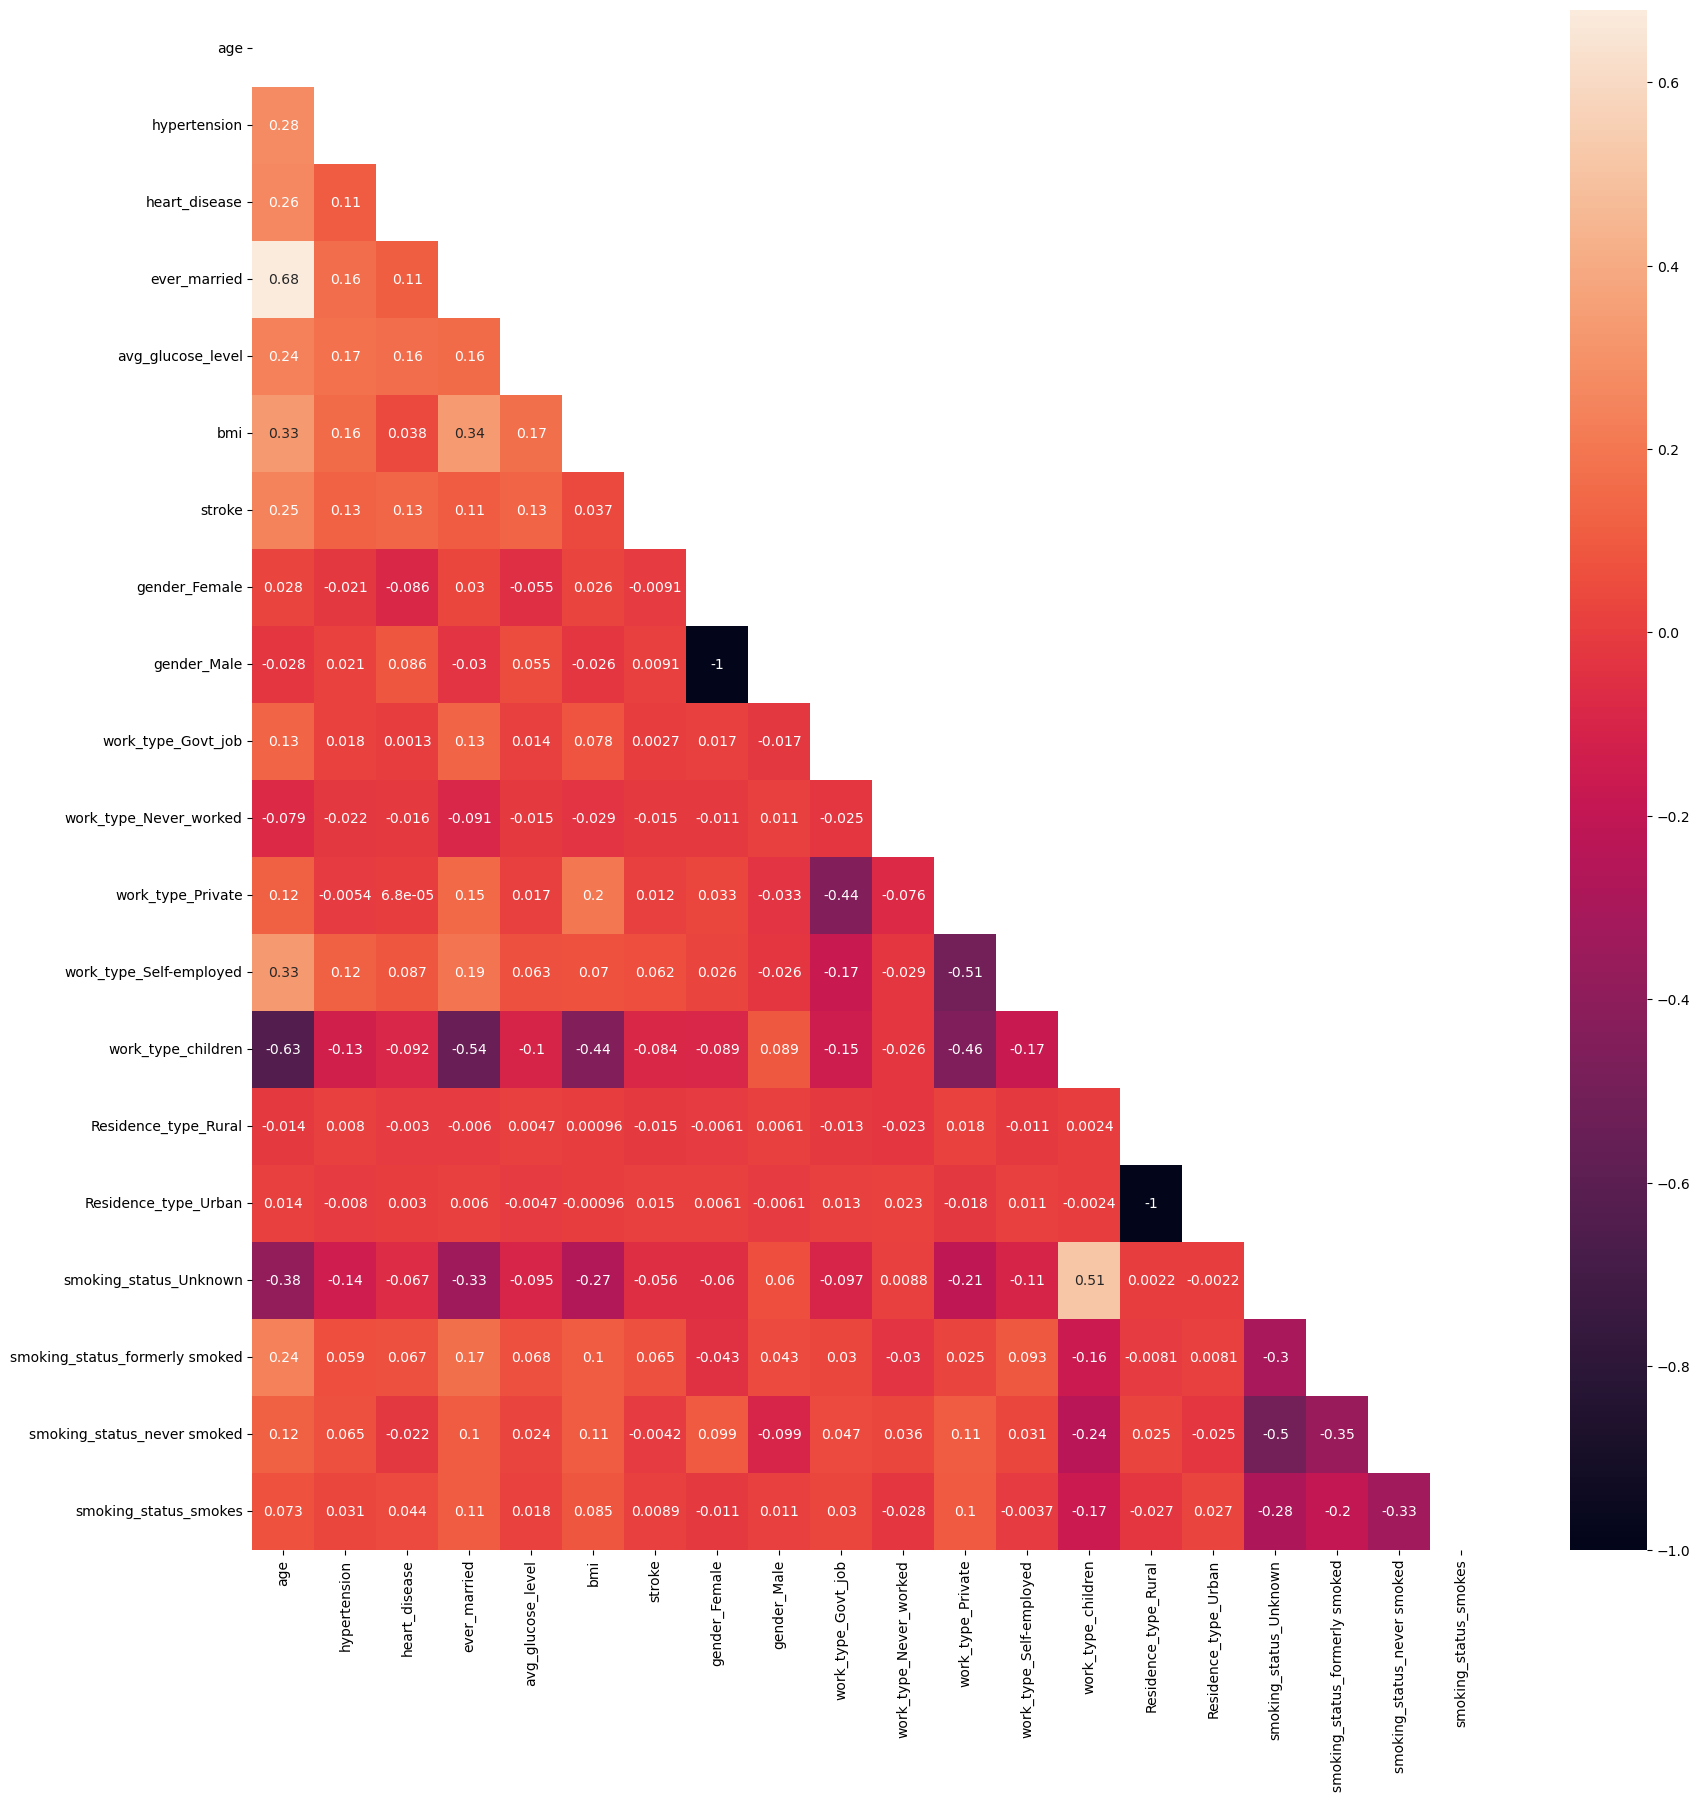

In [38]:

corr=df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,annot=True,mask = np.triu(np.ones_like(corr, dtype=bool)))

In [39]:
#los datos de la columna stroke estan desbalanceados, por lo que usaremos la tecnica de oversampling para balancearlos
df.stroke.value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

In [40]:
# Utilizaremos SMOTE (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
# SMOTE significa Técnica de Sobremuestreo de Minorías Sintéticas.
# Es una técnica utilizada en aprendizaje automático para abordar conjuntos de datos desequilibrados.
# Identificación del Desequilibrio: Comienzas reconociendo que tu conjunto de datos tiene una clase minoritaria, como casos de enfermedades raras en un conjunto de datos médicos.
from imblearn.over_sampling import SMOTE

In [41]:
x = df.drop("stroke",axis=1)
y = df.stroke

In [42]:
x.shape , y.shape , y.value_counts()

((5109, 19),
 (5109,),
 stroke
 0    4860
 1     249
 Name: count, dtype: int64)

In [43]:
smote = SMOTE(sampling_strategy="minority")

In [44]:
#fiteamos
x_smote , y_smote = smote.fit_resample(x,y)                

In [45]:
# ahora tenemos el mismo numero de datos para ambas clases
y_smote.value_counts()

stroke
1    4860
0    4860
Name: count, dtype: int64

In [46]:
x_train , x_test , y_train , y_test = train_test_split(x_smote,y_smote,test_size=0.2,random_state=42,stratify=y_smote)

In [47]:
#escalamos los datos
scaler=StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [48]:
y_train.value_counts() ,y_test.value_counts()

(stroke
 1    3888
 0    3888
 Name: count, dtype: int64,
 stroke
 0    972
 1    972
 Name: count, dtype: int64)

In [49]:
#Lazy predict

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)

print(models)

100%|██████████| 31/31 [00:07<00:00,  4.39it/s]

[LightGBM] [Info] Number of positive: 3888, number of negative: 3888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 7776, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.98               0.98     0.98      0.98   
ExtraTreesClassifier               0.98               0.98     0.98      0.98   
LGBMClassifier                     0.97               0.97     0.97      0.97   
BaggingClassifier                  0.97               0.97     0.97      0.97   
KNeighborsClass

In [50]:
#armamos un random forest classifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [51]:
y_pred = rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9804526748971193


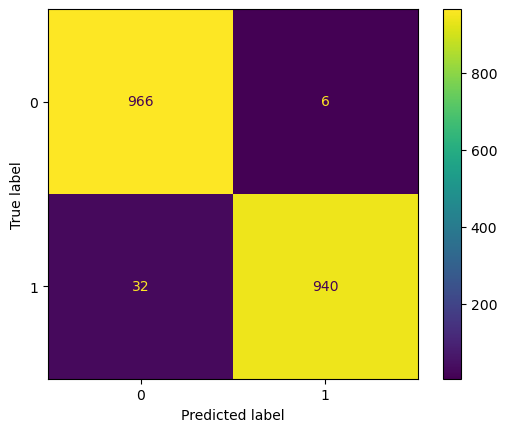

In [52]:
# Validamos con una matriz de confusion
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()